In [1]:
import glob
import os
import pprint 
# import pyyaml

import astropy.units as u
from IPython.display import display
import matplotlib as mp
import matplotlib.pylab as pl
import pandas as pd

import astropy.constants as constants

# from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import astropy.units as u
from astropy.table import Table, vstack

from pystrometry.pystrometry import pjGet_a_barycentre, get_cpsi_spsi_for_2Dastrometry
# from astroquery.exoplanet_orbit_database import ExoplanetOrbitDatabase


In [2]:
LOCAL_PATH = os.path.dirname(os.getcwd())
TEMPORARY_DIR = os.path.join(LOCAL_PATH, 'temp')
if os.path.isdir(TEMPORARY_DIR) is False:
    os.makedirs(TEMPORARY_DIR)
print(LOCAL_PATH)

/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry


In [3]:
pp = pprint.PrettyPrinter(indent=4)     
%matplotlib inline
mp.rcParams['figure.figsize'] = (18, 9)
mp.rcParams['font.size'] = 20
mp.rcParams['ytick.direction'] = 'in'
mp.rcParams['xtick.direction'] = 'in'

In [4]:
# mp.rcParams

In [5]:
# table

In [6]:
save_plot = True

In [7]:
# %pdb

In [8]:
from pystrometry.pystrometry import OrbitSystem 
from collections import OrderedDict

# orb = OrbitSystem()  # default parameters
# orb.plot_orbits() 

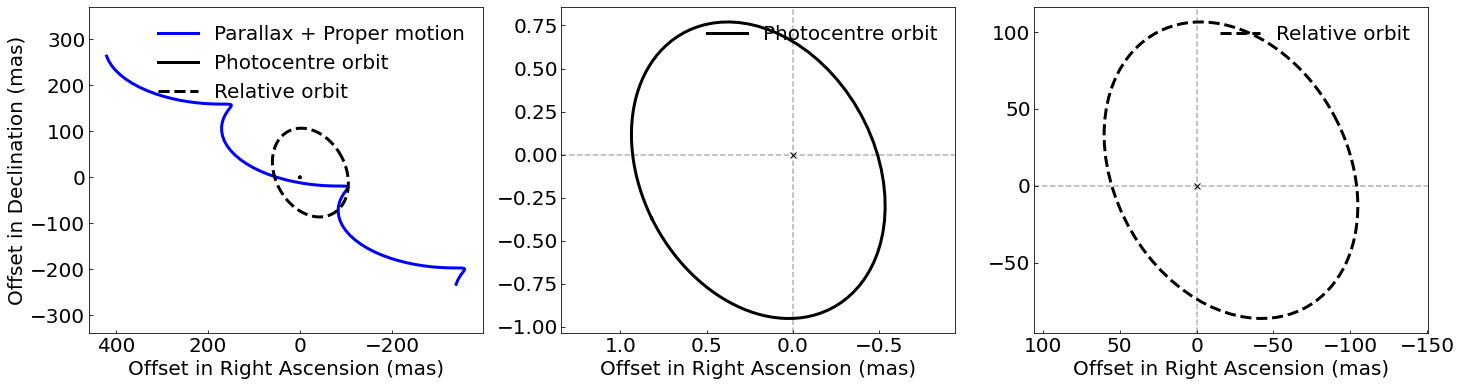

In [26]:
# GJ676A b
attribute_dict = OrderedDict([  ('RA_deg', 262.54667), 
                                  ('DE_deg', -51.6369),
                                  ('absolute_plx_mas', 59.3), 
                                  ('Tp_day', 55410.4), 
                                  ('omega_deg', 87.4),
                                  ('P_day', 1052.1), 
                                  ('ecc', 0.323), 
                                  ('OMEGA_deg', 208.),
                                  ('i_deg', 45.), 
                                  ('m1_MS', 0.71),
                                  ('m2_MJ', 6.7), 
                                  ('muRA_mas', -253.4), 
                                  ('muDE_mas', -177.9)])
                                  
orb = OrbitSystem(attribute_dict)
# orb.plot_orbits() 
# orb.plot_ppm()
# orb.scan_angle_definition

t_mjd = orb.get_t_plot(format='mjd')

delta_ra_star_mas, delta_dec_mas = orb.ppm(t_mjd)

n_figure_columns = 3
n_figure_rows = 1
share_axes = False
line_width = 3
line_color = 'b'
line_style = '-'


fig, axes = pl.subplots(n_figure_rows, n_figure_columns,
                        figsize=(n_figure_columns * 8, n_figure_rows * 6),
                        facecolor='w', edgecolor='k', sharex=share_axes,
                        sharey=share_axes)

axes[0].plot(delta_ra_star_mas, delta_dec_mas, 'k-', lw=line_width, color=line_color, ls=line_style, label='Parallax + Proper motion')    
axes[0].set_ylabel('Offset in Declination (mas)')

timestamps_curve_1D, cpsi_curve, spsi_curve, xi_curve, yi_curve = get_cpsi_spsi_for_2Dastrometry( t_mjd )
phi0_curve = orb.photocenter_orbit(timestamps_curve_1D, spsi_curve, cpsi_curve)
axes[0].plot(phi0_curve[xi_curve], phi0_curve[yi_curve],'k--', lw=line_width, color='k', ls=line_style, label='Photocentre orbit')
axes[0].plot(phi0_curve_relative[xi_curve], phi0_curve_relative[yi_curve],'k--', lw=line_width, color='k', ls='--', label='Relative orbit')

axes[1].plot(phi0_curve[xi_curve], phi0_curve[yi_curve],'k--', lw=line_width, color='k', ls=line_style, label='Photocentre orbit')

    
phi0_curve_relative = orb.relative_orbit_fast(timestamps_curve_1D, spsi_curve, cpsi_curve, shift_omega_by_pi = True)
axes[2].plot(phi0_curve_relative[xi_curve], phi0_curve_relative[yi_curve],'k--', lw=line_width, color='k', ls='--', label='Relative orbit')


for ax in axes:
    ax.legend(loc=1, fancybox=True, framealpha=0.)
    ax.axis('equal')
    ax.set_xlabel('Offset in Right Ascension (mas)')
    ax.invert_xaxis()

for ax in axes[1:]:    
    ax.plot(0,0,'kx')
    ax.axhline(y=0,color='0.7',ls='--',zorder=-50)
    ax.axvline(x=0,color='0.7',ls='--',zorder=-50)
    
    
    
pl.show()    
if save_plot:
    figure_file_name = os.path.join(TEMPORARY_DIR, 'example_orbit.png')
    fig.savefig(figure_file_name, transparent=True, bbox_inches='tight', pad_inches=0.05)        
# axes[1].axis('equal')

In [10]:
ax.axis?

Signature: ax.axis(*args, emit=True, **kwargs)
Docstring:
Convenience method to get or set some axis properties.

Call signatures::

  xmin, xmax, ymin, ymax = axis()
  xmin, xmax, ymin, ymax = axis([xmin, xmax, ymin, ymax])
  xmin, xmax, ymin, ymax = axis(option)
  xmin, xmax, ymin, ymax = axis(**kwargs)

Parameters
----------
xmin, xmax, ymin, ymax : float, optional
    The axis limits to be set.  This can also be achieved using ::

        ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

option : bool or str
    If a bool, turns axis lines and labels on or off. If a string,
    possible values are:

    ======== ==========================================================
    Value    Description
    ======== ==========================================================
    'on'     Turn on axis lines and labels. Same as ``True``.
    'off'    Turn off axis lines and labels. Same as ``False``.
    'equal'  Set equal scaling (i.e., make circles circular) by
             changing axis limits.

In [11]:
1/0

ZeroDivisionError: division by zero

In [ ]:
df = table.to_pandas()